In [62]:
import sys

import matplotlib.pyplot as plt

sys.path.append('../scripts')
import os

import pickle
import time
from multiprocessing import Pool
from time import sleep

import numpy as np
from tqdm.notebook import trange, tqdm
from scripts import centroids_graph_builder, graph_osm_loader, utils, clustering

import networkx as nx


In [236]:
def bi_dijkstra_min_dst(
        graph: nx.Graph,
        start: set[int],
        end: set[int]) -> tuple[float, list[int]]:
    push = heappush
    pop = heappop
    dist = ({},{})
    fringe = ([], [])
    
    c = count()

    for u in start:
        dist[0][u] = (0,0,None)
        push(fringe[0], (0, next(c), 0, u))
    
    for u in end:
        dist[1][u] = (0,0,None)
        push(fringe[1], (0, next(c), 0, u))
    
    adjacency = graph._adj
    union_node = None
    union_dst = float('inf')
    
    while fringe[0] and fringe[1]:
        (d1, _, n1, v1) = pop(fringe[0])
        (d2, _, n2, v2) = pop(fringe[1])
        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist[0] or dist[0][u][0] > vu_dist:
                dist[0][u] = (vu_dist, n1 + 1, v1)
                push(fringe[0], (vu_dist, next(c), n1 + 1, u))
            if u in dist[1]:
                dd = dist[1][u][0] + dist[0][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
        for u, e in adjacency[v2].items():
            vu_dist = d2 + e['length']
            if u not in dist[1] or dist[1][u][0] > vu_dist:
                dist[1][u] = (vu_dist, n2 + 1, v2)
                push(fringe[1], (vu_dist, next(c), n2 + 1, u))
            if u in dist[0]:
                dd = dist[0][u][0] + dist[1][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
        if d1 + d2 > union_dst:
            break

    d1, n1, _ = dist[0][union_node]
    d2, n2, _ = dist[1][union_node]
    path = [0] * (n1 + n2 + 1)
    e = union_node
    i = n1
    while dist[0][e][2] is not None:
        path[i] = e
        i -= 1
        e = dist[0][e][2]
    path[0] = e

    e = union_node
    i = n1
    while dist[1][e][2] is not None:
        path[i] = e
        i += 1
        e = dist[1][e][2]
    path[-1] = e
    return union_dst, path

In [243]:

def build_center_graph(
        graph: nx.Graph,
        communities: list[set[int]],
        cls2n: dict[int: set[int]],
        log: bool = False,
        name: str = 'cluster'
) -> tuple[nx.Graph, dict[int, int]]:
    x_graph = nx.Graph()
    cls2c = {}
    iter = tqdm(enumerate(communities), total=len(communities), desc='find centroids') if log else enumerate(
        communities)
    for cls, _ in iter:
        gc = graph.subgraph( communities[cls])
        min_node = nx.barycenter(gc, weight='length')[0]
        du = graph.nodes()[min_node]
        x_graph.add_node(graph.nodes()[min_node][name], **du)
        cls2c[graph.nodes()[min_node][name]] = min_node

    if len(x_graph.nodes) == 1:
        return x_graph, cls2c
    iter = tqdm(x_graph.nodes(), desc='find edges') if log else x_graph.nodes()
    for u in iter:
        for v in cls2n[u]:
            # l = nx.single_source_dijkstra(graph, source=cls2c[u], target=cls2c[v], weight='length')[0]
            l = bi_dijkstra_min_dst(graph,communities[u],communities[v])[0]
            x_graph.add_edge(u, v, length=l)
    return x_graph, cls2c

In [248]:
GRAPH_ID = 'R13470549'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
g = graph_osm_loader.get_graph(GRAPH_ID)  # загрузка графа
# N = 1000
# p = 0.01
# g = get_rand_graph(N,p)
len(g.nodes), len(g.edges)
utils.get_opt_cluster_count(len(g.nodes))  # оптимальное количество кластеров
g.remove_edges_from(nx.selfloop_edges(g))
name = 'cluster'
cms2 = clustering.resolve_k_means_communities(g, resolution=5, max_iteration=100, cluster_name=name, print_log=True)
print(len(cms2))


100%|██████████| 100/100 [00:00<00:00, 188.25it/s]

56


In [249]:
cls2n = centroids_graph_builder.get_cls2n(g, name=name)  # мапа кластер к соседним кластерам 
g1, cls2c = build_center_graph(g, cms2, cls2n, log=True, name=name)

find centroids:   0%|          | 0/56 [00:00<?, ?it/s]

find edges:   0%|          | 0/56 [00:00<?, ?it/s]

In [253]:
points = [utils.get_node_for_initial_graph_v2(g) for _ in trange(1000, desc='generate points')]

generate points:   0%|          | 0/1000 [00:00<?, ?it/s]

In [251]:
dst = dict(tqdm(nx.all_pairs_dijkstra_path_length(g1, weight='length'), total=len(g1.nodes())))
d_clusters = {}
d_nodes = {}
for u in tqdm(dst):
    for v in dst[u]:
        d_clusters[u, v] = dst[u][v]
        d_clusters[v, u] = dst[u][v]

for u, d in tqdm(g.nodes(data=True)):
    c = cls2c[d[name]]
    l = nx.single_source_dijkstra(g, u, c, weight='length')[0]
    d_nodes[u] = l
from scripts import ch
nodes = g.nodes()

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/715 [00:00<?, ?it/s]

In [234]:
c1,c2=cms2[0],cms2[1]
l = 1e10
for u in c1:
    for v in c2:
        l = min(l, nx.single_source_dijkstra(g,u,v,weight='length')[0])
l, bi_dijkstra_min_dst(g, c1,c2)[0]


KeyboardInterrupt



In [252]:
d_clusters = {}
d_nodes = {}
for u in tqdm(g1.nodes()):
    for v in g1.nodes():
        if u == v:
            l=0
        else:
            l=bi_dijkstra_min_dst(g, cms2[u], cms2[v])[0]
        d_clusters[u, v] = l
        d_clusters[v, u] = l

for u, d in tqdm(g.nodes(data=True)):
    c = cls2c[d[name]]
    l = nx.single_source_dijkstra(g, u, c, weight='length')[0]
    d_nodes[u] = l
from scripts import ch
nodes = g.nodes()

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/715 [00:00<?, ?it/s]

In [132]:
from heapq import heappop, heappush
from itertools import count
import networkx as nx


def dijkstra_pfa(graph: nx.Graph,
                 start: int,
                 end: int,
                 cms: set[int] | None = None) -> \
        tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    adjacency = graph._adj
    nodes = graph.nodes()
    c = count()
    push = heappush
    pop = heappop
    dist = {}
    pred = {}
    fringe = []
    push(fringe, (0.0, next(c), 0, start, None))
    while fringe:
        (d, _, n, v, p) = pop(fringe)
        if v in dist:
            continue
        dist[v] = (d, n)
        pred[v] = p
        if v == end:
            break
        for u, e in adjacency[v].items():
            if cms and nodes[u]['cluster'] not in cms:
                continue
            vu_dist = d + e['length']
            if u not in dist:
                push(fringe, (vu_dist, next(c), n + 1, u, v))
    d, n = dist[end]
    n += 1
    path = [None] * n
    i = n - 1
    e = end
    while i >= 0:
        path[i] = e
        i -= 1
        e = pred[e]
    return d, path, set(dist.keys())


def bi_dijkstra_pfa(graph: nx.Graph,
                    start: int,
                    end: int,
                    cms: set[int] | None = None
                    ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    push = heappush
    pop = heappop
    dist = ({start: (0, 0, None)}, {end: (0, 0, None)})
    fringe = ([], [])
    c = count()

    adjacency = graph._adj
    nodes = graph.nodes()

    push(fringe[0], (0, next(c), 0, start))
    push(fringe[1], (0, next(c), 0, end))

    union_node = None
    union_dst = float('inf')
    while fringe[0] and fringe[1]:
        (d1, _, n1, v1) = pop(fringe[0])
        (d2, _, n2, v2) = pop(fringe[1])
        for u, e in adjacency[v1].items():
            if cms and nodes[u]['cluster'] not in cms:
                continue

            vu_dist = d1 + e['length']
            if u not in dist[0] or dist[0][u][0] > vu_dist:
                dist[0][u] = (vu_dist, n1 + 1, v1)
                push(fringe[0], (vu_dist, next(c), n1 + 1, u))
            if u in dist[1]:
                dd = dist[1][u][0] + dist[0][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
        for u, e in adjacency[v2].items():
            if cms and nodes[u]['cluster'] not in cms:
                continue

            vu_dist = d2 + e['length']
            if u not in dist[1] or dist[1][u][0] > vu_dist:
                dist[1][u] = (vu_dist, n2 + 1, v2)
                push(fringe[1], (vu_dist, next(c), n2 + 1, u))
            if u in dist[0]:
                dd = dist[0][u][0] + dist[1][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
        if d1 + d2 > union_dst:
            break

    d1, n1, _ = dist[0][union_node]
    d2, n2, _ = dist[1][union_node]
    path = [0] * (n1 + n2 + 1)
    e = union_node
    i = n1
    while dist[0][e][2] is not None:
        path[i] = e
        i -= 1
        e = dist[0][e][2]
    path[0] = e

    e = union_node
    i = n1
    while dist[1][e][2] is not None:
        path[i] = e
        i += 1
        e = dist[1][e][2]
    path[-1] = e
    return union_dst, path, set(dist[0].keys()).union(set(dist[1].keys()))


In [255]:
def func(u, v):
    c1 = nodes[u]['cluster']
    c2 = nodes[v]['cluster']
    pi_l = abs(d_clusters[c1, c2] - d_nodes[v])
    l = abs(pi_l - d_nodes[u])
    return l/2

In [209]:
dst = dict(tqdm(nx.all_pairs_dijkstra_path_length(g, weight='length'), total=len(g.nodes)))

  0%|          | 0/715 [00:00<?, ?it/s]

In [217]:
ll = []
for u in tqdm(g.nodes()):
    for v in g.nodes():
        f = func(u,v)
        l = dst[u][v]
        if abs(f-l) > 0.001 and f > l:
            print(f,l)
            
            ll.append(f/l)
max(ll)

  0%|          | 0/715 [00:00<?, ?it/s]

ValueError: max() arg is an empty sequence

In [165]:
def dijkstra_pfa_cls(graph: nx.Graph,
                    start: int,
                    end: int
                    ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    push = heappush
    pop = heappop
    dist = {start: (0, None)}
    fringe = []
    c = count()
    adjacency = graph._adj
    push(fringe, (0, next(c), 0,func(start, end), start))

    while fringe:
        (_, _, d1,l1, v1) = pop(fringe)
        if v1 == end:
            break
        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist or dist[u][0] > vu_dist:
                dist[u] = (vu_dist, v1)
                lu =  min(func(u,end),1e5)
                push(fringe, (vu_dist + lu, next(c), vu_dist,lu, u))
    
    path = [end]
    e = end
    while dist[e][1] is not None:
        e = dist[e][1]
        path = [e] + path
    l = 0
    e = g.edges()
    for i in range(len(path)-1):
        p1,p2=path[i],path[i+1]
        l+=e[p1,p2]['length']
    return l, path, set(dist.keys())

In [175]:
def bi_dijkstra_pfa_cls(graph: nx.Graph,
                    start: int,
                    end: int
                    ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    push = heappush
    pop = heappop
    dist = ({start: (0, None)}, {end: (0, None)})
    fringe = ([], [])
    c = count()
    adjacency = graph._adj

    push(fringe[0], (0, next(c), 0,func(start,end), start))
    push(fringe[1], (0, next(c), 0,func(start,end), end))

    union_node = None
    union_dst = float('inf')
    while fringe[0] and fringe[1]:
        (_, _, d1,l1, v1) = pop(fringe[0])
        (_, _, d2,l2,v2) = pop(fringe[1])
        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist[0] or dist[0][u][0] > vu_dist:
                dist[0][u] = (vu_dist, v1)
                lu =  min(func(u,end), l1+e['length'])
                push(fringe[0], (vu_dist + lu, next(c), vu_dist,lu, u))
                if u in dist[1]:
                    dd = dist[1][u][0] + dist[0][u][0]
                    if dd < union_dst:
                        union_dst = dd
                        union_node = u

        for u, e in adjacency[v2].items():
            vu_dist = d2 + e['length']
            if u not in dist[1] or dist[1][u][0] > vu_dist:
                dist[1][u] = (vu_dist, v2)
                lu =  min(func(u,start), l2+e['length'])
                push(fringe[1], (vu_dist + lu, next(c), vu_dist, lu, u))
                if u in dist[0]:
                    dd = dist[0][u][0] + dist[1][u][0]
                    if dd < union_dst:
                        union_dst = dd
                        union_node = u

        if d1+d2>union_dst:
            break

    d1, _ = dist[0][union_node]
    d2, _ = dist[1][union_node]
    path = []

    e = union_node
    while dist[0][e][1] is not None:
        path = [e] + path
        e = dist[0][e][1]
    path= [e] + path

    e = union_node
    while dist[1][e][1] is not None:
        e = dist[1][e][1]
        path += [e]

    l = 0
    e = g.edges()
    for i in range(len(path)-1):
        p1,p2=path[i],path[i+1]
        l+=e[p1,p2]['length']
    return l, path, set(dist[0].keys()).union(set(dist[1].keys()))

In [12]:
chg = ch.build_ch_graph(g)

100%|██████████| 715/715 [00:00<00:00, 3734.98it/s]


In [157]:
pos = {u:[d['x'],d['y']] for u,d in g.nodes(data=True)}


In [115]:
p1,p2= points[4]

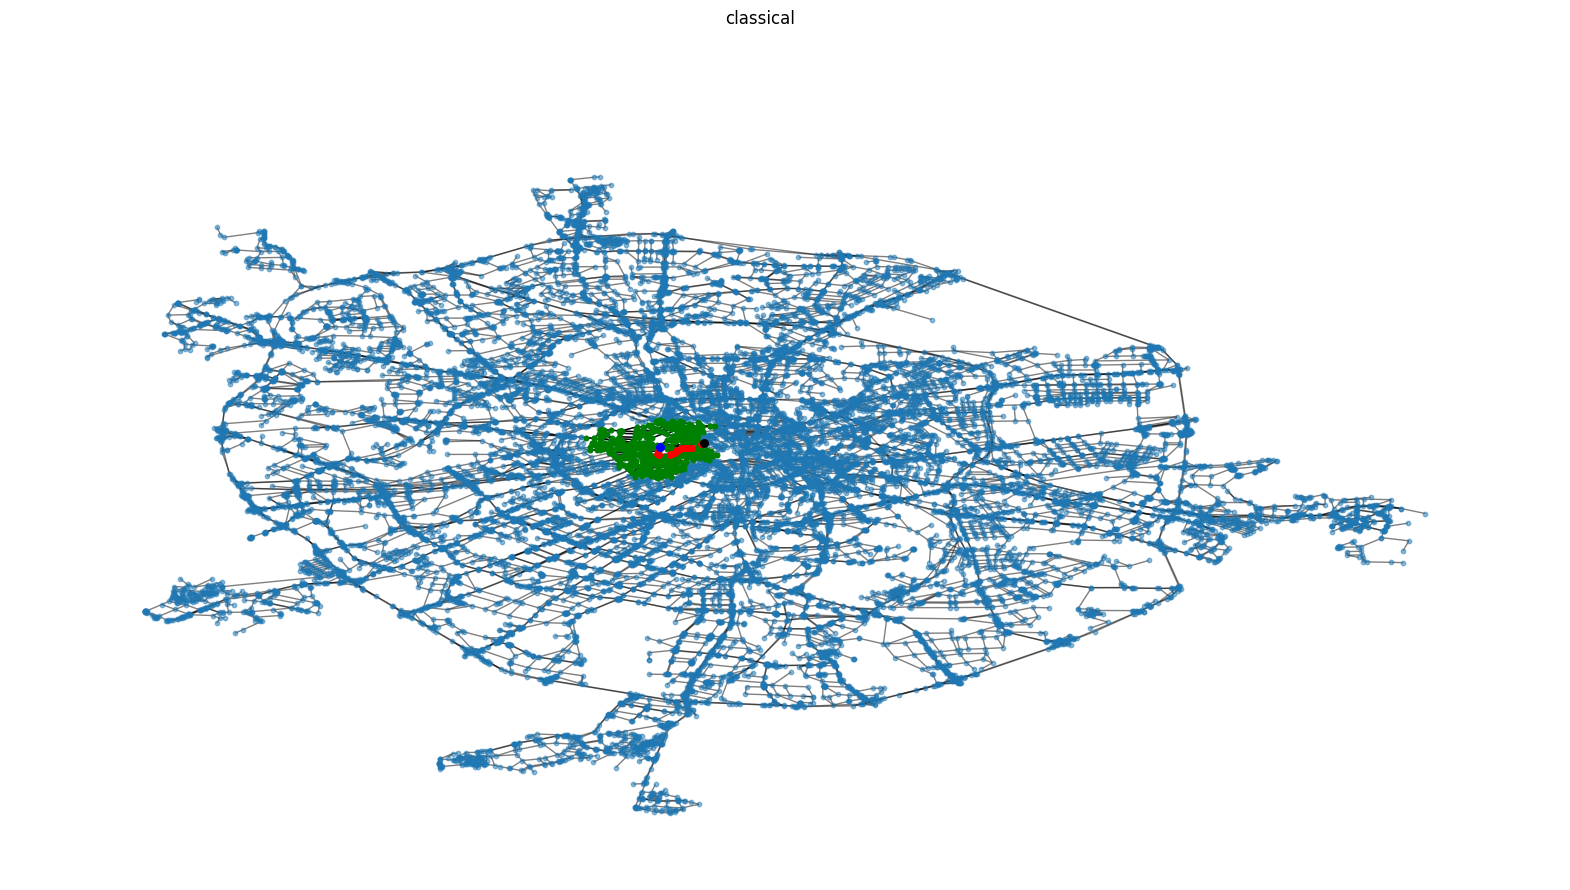

In [126]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
l,path,nn = dijkstra_pfa(g, p1,p2)
f.suptitle('classical')
nx.draw(g,pos=pos, ax = ax, node_size = 10, alpha=0.5)
nx.draw(g.subgraph(nn),pos=pos, ax = ax, node_size = 10, node_color='green')
nx.draw(g.subgraph(path),pos=pos, ax = ax, node_size = 15, node_color='red', edge_color='red',width = 2)
nx.draw(g.subgraph(p1),pos=pos, ax = ax, node_size = 30, node_color='blue', edge_color='red',width = 2)
nx.draw(g.subgraph(p2),pos=pos, ax = ax, node_size = 30, node_color='black', edge_color='red',width = 2)
# plt.show()

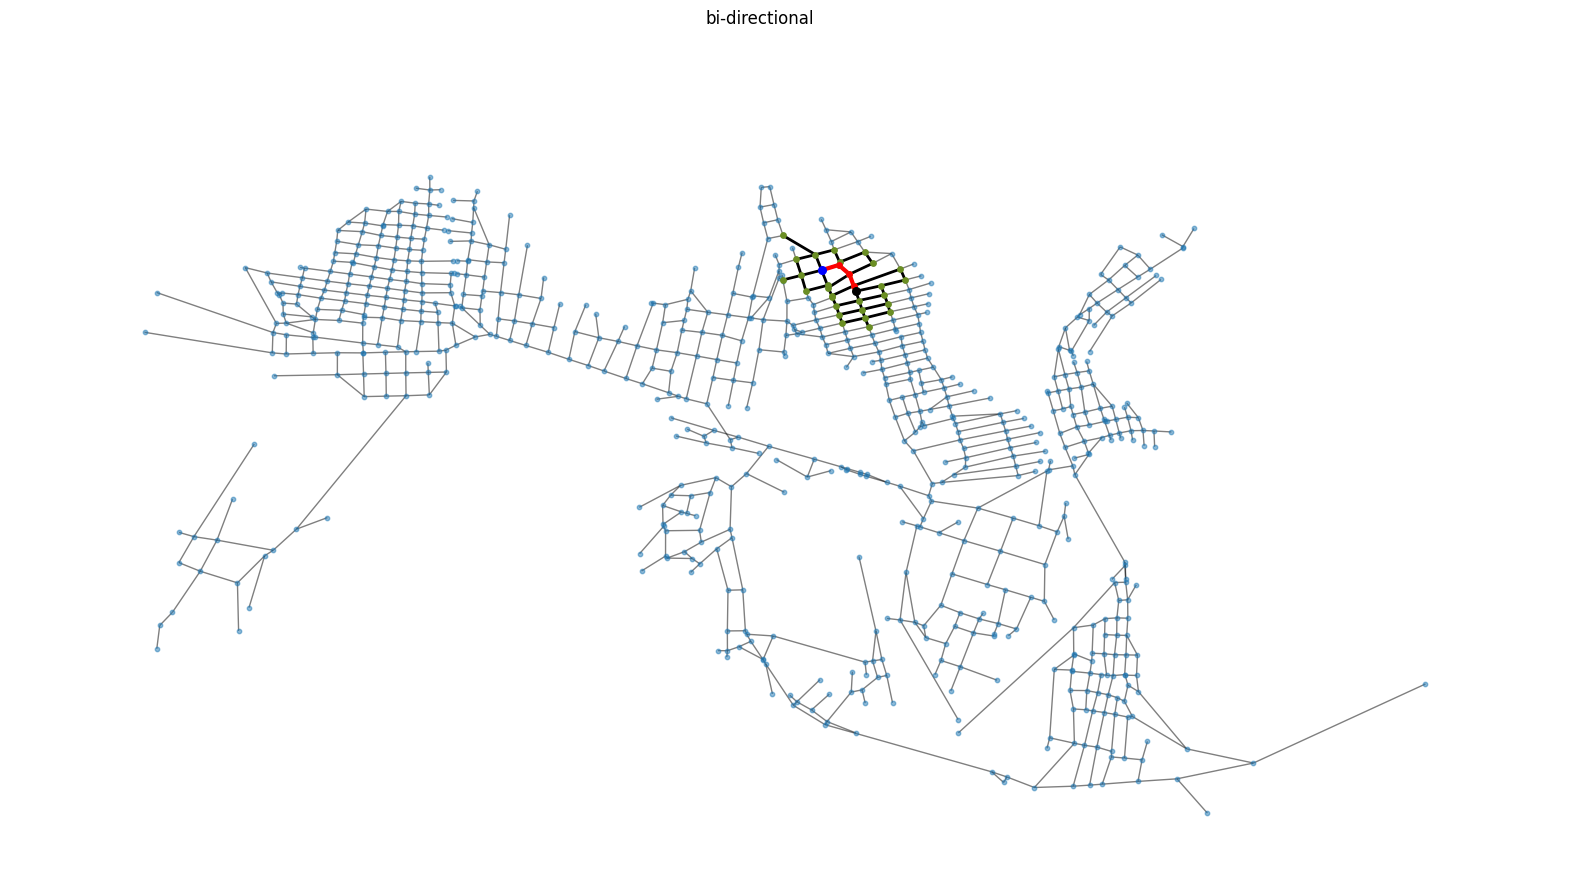

In [193]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
l,path,nn = bi_dijkstra_pfa(g, p1,p2)
f.suptitle('bi-directional')
nx.draw(g,pos=pos, ax = ax, node_size = 10, alpha=0.5)
nx.draw(g.subgraph(nn),pos=pos, ax = ax, node_size = 15, node_color='olivedrab',width = 2)
nx.draw(g.subgraph(path),pos=pos, ax = ax, node_size = 15, node_color='red', edge_color='red',width = 3)
nx.draw(g.subgraph(p1),pos=pos, ax = ax, node_size = 30, node_color='blue', edge_color='red',width = 3)
nx.draw(g.subgraph(p2),pos=pos, ax = ax, node_size = 30, node_color='black', edge_color='red',width = 3)
# plt.show()

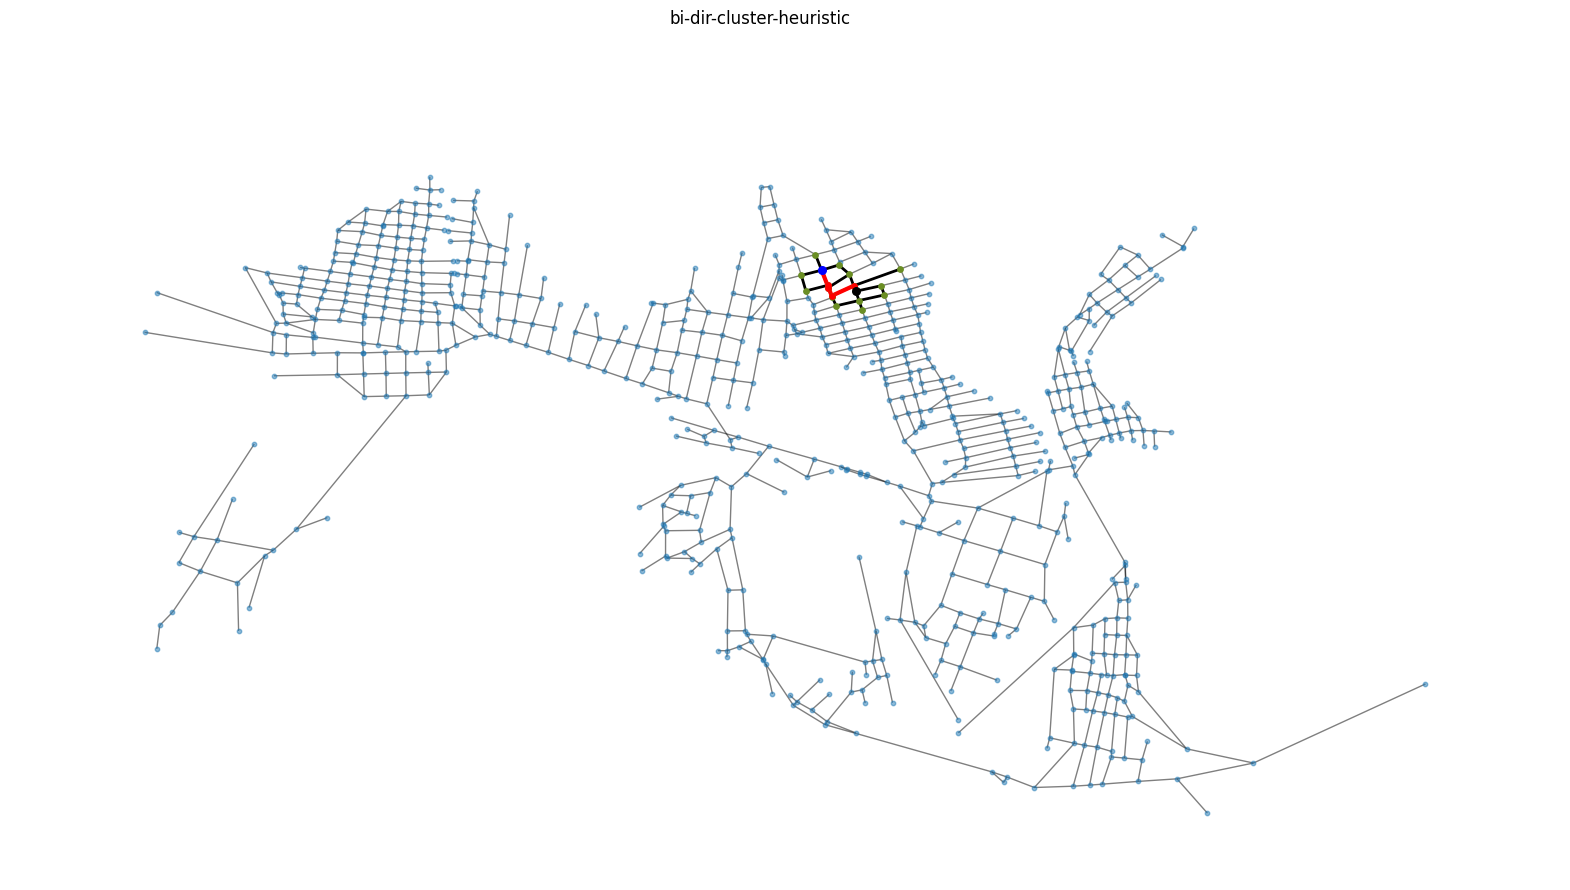

In [194]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
l,path,nn = bi_dijkstra_pfa_cls(g, p1,p2)

f.suptitle('bi-dir-cluster-heuristic')
nx.draw(g,pos=pos, ax = ax, node_size = 10, alpha=0.5)
nx.draw(g.subgraph(nn),pos=pos, ax = ax, node_size = 15, node_color='olivedrab',width = 2)
nx.draw(g.subgraph(path),pos=pos, ax = ax, node_size = 15, node_color='red', edge_color='red',width = 3)
nx.draw(g.subgraph(p1),pos=pos, ax = ax, node_size = 30, node_color='blue', edge_color='red',width = 3)
nx.draw(g.subgraph(p2),pos=pos, ax = ax, node_size = 30, node_color='black', edge_color='red',width = 3)
# plt.show()

In [179]:
# f, ax = plt.subplots(1, 1, figsize=(20, 10))
# l,path,nn = ch_pfa(chg, p1,p2)
# f.suptitle('cluster-heuristic')
# nx.draw(g,pos=pos, ax = ax, node_size = 10, alpha=0.5)
# nx.draw(g.subgraph(nn),pos=pos, ax = ax, node_size = 15, node_color='olivedrab',width = 2)
# nx.draw(g.subgraph(path),pos=pos, ax = ax, node_size = 15, node_color='red', edge_color='red',width = 3)
# nx.draw(g.subgraph(p1),pos=pos, ax = ax, node_size = 30, node_color='blue', edge_color='red',width = 3)
# nx.draw(g.subgraph(p2),pos=pos, ax = ax, node_size = 30, node_color='black', edge_color='red',width = 3)
# # plt.show()

In [185]:
func(p1,p1), nx.single_source_dijkstra(g, p1,p2,weight='length')[0]    

(0.0, 13135.913)

In [148]:
ll = []
for p1, p2 in points:
    l1,l2=func(p1,p2), nx.single_source_dijkstra(g, p1,p2,weight='length')[0]    
    ll.append(l1/l2)

In [149]:
max(ll)

0.9983364625822552

In [136]:
p1,p2 = points[2]


(7562.765999999999, 6878.5239999999985)

In [256]:


from scripts import dijkstra

NUM_ITERATION = 2  # чтобы уменьшить ошибку при вычислении времени выполнения, при каждом замере время меряется для NUM_ITERATION повторений
WORKER = 4  # количество потоков


def do_calc(data):
    pps, i = data

    stat = {}
    stat['l'] = []
    stat['h_l'] = []
    stat['p'] = []
    stat['h_p'] = []
    stat['time_l'] = []
    stat['time_h'] = []

    stat['delta'] = []
    # чисто чтобы tqdm нормально прогрузился 
    sleep(i / 10)
    print('start', i)

    for p1, p2 in tqdm(pps, desc='find paths', position=i):
        if (p1, p2) in stat:
            continue
        # класический дейкстра
        l, p = None, None
        start = time.time()
        for i in range(NUM_ITERATION):
            l, p = nx.single_source_dijkstra(g, p1, p2, weight='length')
        time_l = time.time() - start

        # иерархический
        h_l, h_p = None, None
        start = time.time()
        for _ in range(NUM_ITERATION):
            # h_l, h_p = bi_dijkstra_pfa(g, p1,p2) #find_path_length_h(g, g1,cms, p1, p2)
            h_l, h_p,_ = dijkstra_pfa_cls(g, p1, p2)  #find_path_length_h(g, g1,cms, p1, p2)
            # cls = set([g.nodes()[u]['cluster'] for u in h_p])
            # cls1 = cls.copy()
            # for c in cls:
            #     for cc in cls2n[c]:
            #         cls1.add(cc)
            # h_l, h_p = dijkstra.dijkstra_pfa(g, p1,p2, cls1)  #find_path_length_h(g, g1,cms, p1, p2)
            # h_l,h_p=ch_pfa(chg, p1,p2)
            # h_l, h_p = nx.astar_path_length(g, p1,p2,weight='length', heuristic=func), []
        time_h = time.time() - start

        delta = (h_l - l) / l * 100
        stat['l'].append(l)  # длина обычного пути
        stat['h_l'].append(h_l)  # длина иерархического пути
        stat['p'].append(p)  # обычный путь
        stat['h_p'].append(h_p)  # иерархический путь
        stat['delta'].append(delta)  # разница в длине
        stat['time_l'].append(time_l)  # обычное время 
        stat['time_h'].append(time_h)  # иерархическое
    return stat


data = [([p for p in points[i::WORKER]], i) for i in range(WORKER)]
# do_calc(data[0])
with Pool(WORKER) as p:
    res = p.map(do_calc, data)

stat = {}
for l in res:
    for d in l:
        if d not in stat:
            stat[d] = []
        stat[d].extend(l[d])
print(f"err_mean: {np.mean(stat['delta']):.2f}")
print(f"err_min: {np.min(stat['delta']):.2f}")
print(f"err_max: { np.max(stat['delta']):.2f}",)
print(np.mean(np.array(stat['time_l']) / np.array(stat['time_h'])))

start 0


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 1


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 2


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 3


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

err_mean: 0.03
err_min: 0.00
err_max: 9.18
1.624010269699693


In [219]:
p1,p2 = points[0]

In [220]:
nx.single_source_dijkstra(g,p1,p2,weight='length')

(5889.803999999998,
 [2028570274,
  2028570158,
  1521196313,
  1521196303,
  1521196300,
  1521196281,
  1521196280,
  2028569909,
  1526038980,
  1526038979,
  1526038968,
  1526038959,
  1526038958,
  2027953685,
  620100728,
  1289849105,
  1289849100,
  1289849106,
  1289849102,
  1289849113,
  620100727,
  2027953680,
  1576825014,
  1576825009,
  1576825000,
  2028392660,
  2027953712,
  1576825079,
  1576825071,
  1576825066,
  1576825062,
  2028474119,
  2028392680,
  1336309442,
  1576825045,
  1576825043,
  2028392619,
  2028392611,
  1576825007,
  1576825017,
  1576825004,
  1576825011,
  1576824995,
  2028392555,
  2028392571,
  3858648472,
  3858648470,
  1576824970,
  3858648467,
  1576824947])

In [221]:
bi_dijkstra_pfa_cls(g,p1,p2)

(5889.803999999998,
 [2028570274,
  2028570158,
  1521196313,
  1521196303,
  1521196300,
  1521196281,
  1521196280,
  2028569909,
  1526038980,
  1526038979,
  1526038968,
  1526038959,
  1526038958,
  2027953685,
  620100728,
  1289849105,
  1289849100,
  1289849106,
  1289849102,
  1289849113,
  620100727,
  2027953680,
  1576825014,
  1576825009,
  1576825000,
  2028392660,
  2027953712,
  1576825079,
  1576825071,
  1576825066,
  1576825062,
  2028474119,
  2028392680,
  1336309442,
  1576825045,
  1576825043,
  2028392619,
  2028392611,
  1576825007,
  1576825017,
  1576825004,
  1576825011,
  1576824995,
  2028392555,
  2028392571,
  3858648472,
  3858648470,
  1576824970,
  3858648467,
  1576824947],
 {251528356,
  251528359,
  620100726,
  620100727,
  620100728,
  620100731,
  620100732,
  620101234,
  620101236,
  620101502,
  935208512,
  935208661,
  1211686665,
  1211686690,
  1211686753,
  1211686791,
  1271789092,
  1271789168,
  1271789200,
  1289849066,
  1289849071,

In [222]:
max_err_idx = np.argmax(stat['delta'])


In [223]:
path = stat['p'][max_err_idx]
h_path = stat['h_p'][max_err_idx]

In [227]:
path

[2027953760,
 2027953707,
 1289849106,
 1289849102,
 1289849113,
 620100727,
 2027953680,
 1576825014,
 1576825009,
 1576825000,
 2028392660,
 2027953712,
 1576825079,
 1576825071,
 1576825066,
 1576825062,
 2028474119,
 2028392680,
 1336309442,
 1576825045,
 1576825043,
 2028392623]

In [224]:
h_path

[2027953760,
 2027953707,
 1289849106,
 1289849102,
 1289849113,
 620100727,
 1289849092,
 1289849094,
 1289849118,
 2027953643,
 2027953636,
 1576824992,
 2027953698,
 2028392622,
 1576825071,
 1576825066,
 1576825062,
 2028474119,
 2028392680,
 1336309442,
 1576825045,
 1576825043,
 2028392623]

In [228]:
len(path), len(h_path)

(22, 23)

In [226]:
print(np.array(path) - np.array(h_path))

ValueError: operands could not be broadcast together with shapes (22,) (23,) 

In [191]:
stat['l'][max_err_idx], stat['h_l'][max_err_idx]

(409.518, 462.834)

In [192]:
p1,p2 = path[0], path[-1]

In [217]:
labels = {u:d['cluster'] for u,d in g.nodes(data=True)}

In [218]:
pos_l = {u:[d['x']+0.001,d['y']+0.001] for u,d in g.nodes(data=True)}


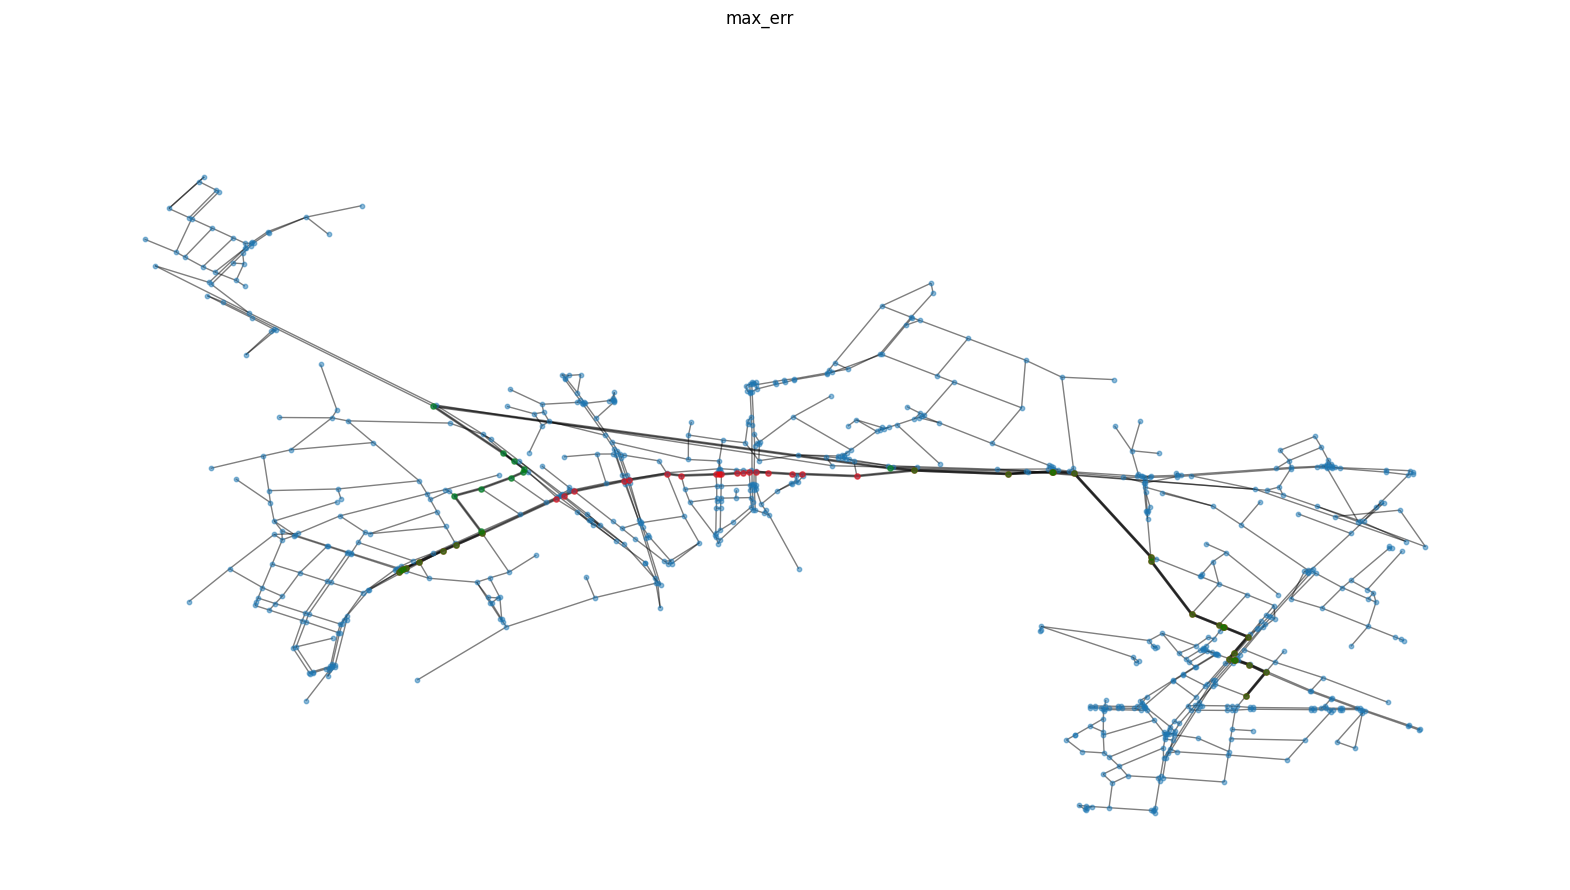

In [222]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
f.suptitle('max_err')
cls = set([g.nodes()[u]['cluster'] for u in h_path])
cls1 = cls.copy()
for c in cls:
    for cc in cls2n[c]:
        cls1.add(cc)
cls = set([g.nodes()[u]['cluster'] for u in path])
for c in cls:
    cls1.add(c)
    for cc in cls2n[c]:
        cls1.add(cc)

nx.draw(centroids_graph_builder.extract_cluster_list_subgraph(g,cls1, cms2),pos=pos, ax = ax, node_size = 10, alpha=0.5)
nx.draw(g.subgraph(path),pos=pos, ax = ax, node_size = 15, node_color='red',width = 2,alpha = 0.5)
nx.draw(g.subgraph(h_path),pos=pos, ax = ax, node_size = 15, node_color='green',width = 2,alpha = 0.5)
# nx.draw_networkx_labels(g,pos_l,labels=labels,font_size=6)